### Import libraries

In [338]:
from fpdf import FPDF
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### PDF Class

In [339]:
class PDF(FPDF):
    def add_text(
        self, title, x, y, w=210, h=297, font="Arial", fontsize=16, align="C", color=(0, 0, 0), border=0,style=""
    ):
        self.set_xy(x, y)
        if style:
            self.set_font(font, style, fontsize)
        else:
            self.set_font(font, "", fontsize)
        self.set_text_color(*color)
        self.cell(w=w, h=h, align=align, txt=title, border=border)

    def add_image(self, path, x, y, w=None, h=None):
        if w is None and h is None:
            self.image(path, x, y)
        elif w is None:
            self.image(path, x, y, h=h)
        elif h is None:
            self.image(path, x, y, w=w)
        else:
            self.image(path, x, y, w=w, h=h)

## Front Page

In [340]:
A4x = 210
A4y = 297-21
margin = 20

pdf = PDF()
pdf.add_page()
pdf.add_text("Pizzas Maven", 0, margin, h=20, fontsize=32,style="B")
pdf.add_text("Reporte Ejecutivo 2016", 0, margin+20, h=20, fontsize=24,style="B")
pdf.add_image("images/maven.jpg", margin, margin+40+2*margin, w=A4x - 2 * margin)
pdf.add_text("By Sergio Herreros",0,A4y-20,w=A4x-margin,h=20,align="R", fontsize=12,style="I")

### Load Data

In [341]:
orders = pd.read_csv("data/orders_2016_clean.csv")
orders.sort_values(by=["date","order_id"], inplace=True)
orders["date"] = pd.to_datetime(orders["date"])
orders.reset_index(drop=True, inplace=True)
orders.head()

,order_id,date
0,1,2016-01-01
1,2,2016-01-01
2,4,2016-01-01
3,5,2016-01-01
4,6,2016-01-01


In [342]:
order_details = pd.read_csv("data/order_details_2016_clean.csv")
order_details.sort_values(by=["order_id"], inplace=True)
order_details.reset_index(drop=True, inplace=True)
'''one or two letters from smlx using regex'''
order_details["pizza_id"]=order_details["pizza_id"].str.replace(r"_[smlx]{1,3}$","",regex=True)
order_details.head()

,order_id,pizza_id,quantity
0,1,hawaiian,1.0
1,2,five_cheese,1.0
2,2,thai_ckn,1.0
3,2,classic_dlx,1.0
4,2,mexicana,1.0


In [343]:
orders = orders.merge(order_details, on="order_id")
orders.head()

,order_id,date,pizza_id,quantity
0,1,2016-01-01,hawaiian,1.0
1,2,2016-01-01,five_cheese,1.0
2,2,2016-01-01,thai_ckn,1.0
3,2,2016-01-01,classic_dlx,1.0
4,2,2016-01-01,mexicana,1.0


### PLOTS

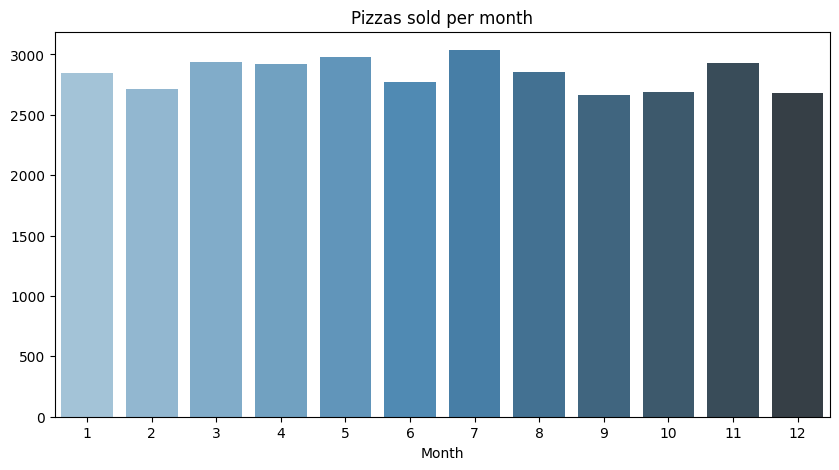

In [344]:
'''plot of number of pizzas sold per month'''
orders["month"] = orders["date"].dt.month
'''using seaborn with colors'''
pizzas_mes=orders.groupby("month")["quantity"].sum()
plt.figure(figsize=(10,5))
sns.barplot(x=pizzas_mes.index, y=pizzas_mes.values, palette="Blues_d")
plt.title("Pizzas sold per month")
plt.xlabel("Month")
plt.savefig("images/pizzas_mes.png", dpi=300, bbox_inches="tight")

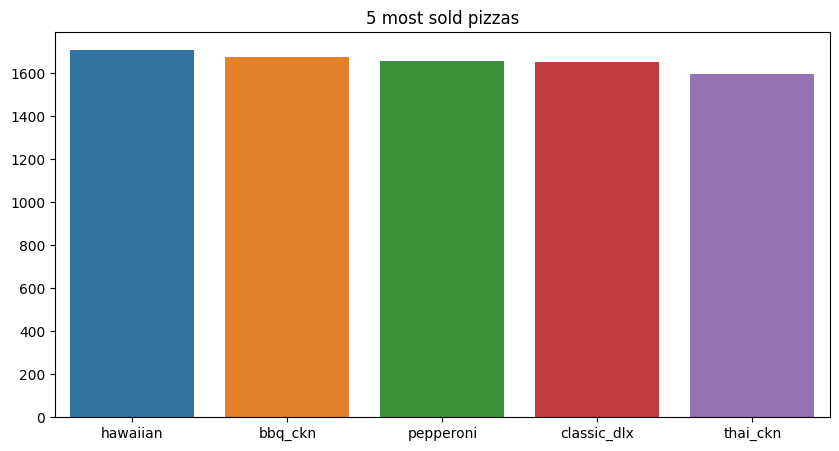

In [345]:
'''5 more sold pizzas'''
pizzas=orders.groupby("pizza_id")["quantity"].sum()
pizzas.sort_values(ascending=False, inplace=True)
pizzas=pizzas[:5]
plt.figure(figsize=(10,5))
sns.barplot(x=pizzas.index, y=pizzas.values)
plt.title("5 most sold pizzas")
plt.xlabel("");
plt.savefig("images/pizzas.png", dpi=300, bbox_inches="tight")

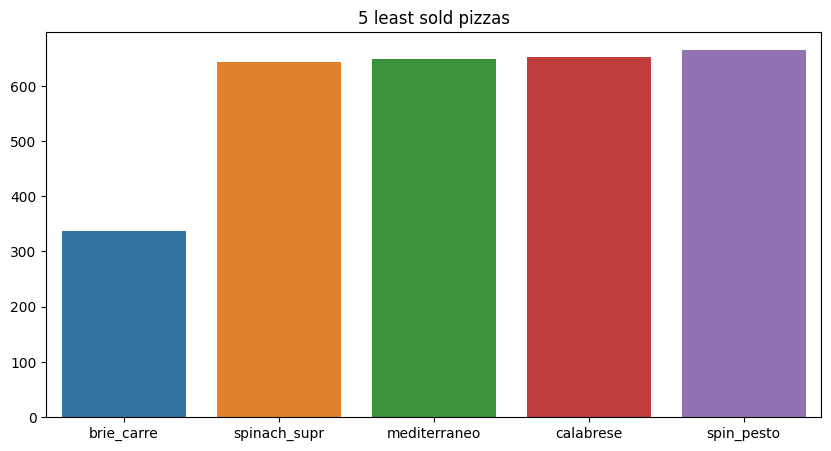

In [346]:
'''5 less sold pizzas'''
pizzas=orders.groupby("pizza_id")["quantity"].sum()
pizzas.sort_values(ascending=True, inplace=True)
pizzas=pizzas[:5]
plt.figure(figsize=(10,5))
sns.barplot(x=pizzas.index, y=pizzas.values)
plt.title("5 least sold pizzas")
plt.xlabel("");
plt.savefig("images/pizzas2.png", dpi=300, bbox_inches="tight")

In [347]:
pdf.add_page()
pdf.add_text("General Report", 0, margin, h=20, fontsize=18)
pdf.add_image("images/pizzas_mes.png", margin, margin+40+2*margin, w=A4x - 2 * margin)
pdf.add_page()
pdf.add_text("General Report", 0, margin, h=20, fontsize=16)
pdf.add_image("images/pizzas.png", margin, margin+40+2*margin, w=A4x - 2 * margin)
pdf.add_page()
pdf.add_text("General Report", 0, margin, h=20, fontsize=16)
pdf.add_image("images/pizzas2.png", margin, margin+40+2*margin, w=A4x - 2 * margin)

### Predictions

In [348]:
pdf.add_page()
pdf.add_text("Predictions Report", 0, margin, h=20, fontsize=18)
txt=["Here is how the model predicts a given ingredient in may 2016.",
"To check if our model is aplicable in our daily basis, we'll see how well it predicts ",
"ingredients on days that are not in the training set.",
"The first 7 days are in the training set, the rest are not.",
" ",
"The confidence interval is given by the mean absolute error of that ingredient."
" ",
"As we can see, the model fits the data of two weeks in the future pretty well, and then it starts to fail but slightly.",
]
sep=2
for i, t in enumerate(txt):
    pdf.add_text(t, margin, 3*margin+i*(pdf.font_size+sep), w=A4x - 2 * margin,h=10, fontsize=10)
pdf.add_image("images/daily_bbq_ckn.png", margin, margin+40+2*margin+3*margin, w=A4x - 2 * margin)

In [349]:
pdf.add_page()
pdf.add_text("Predictions Report", 0, margin, h=20, fontsize=18)
txt=["Now that we know that our model predicts decently the daily stock of ingredients",
"so we can use it to predict the stock of ingredients for an entire week.",
"First, we'll sum up the daily stock of ingredients for each week.",
"Then, we'll add a margin error so that we can be sure that we have enough ingredients.",
"This margin error is the mean absolute error for each ingredient, and it is weighted by a hyperparameter alpha.",
"Finally, lets define a parameter to make the predictions realistic.",
"Let's say we need to make the order of ingredients for the next week on tuesdays.",
"Then, we'll be missing data from tuesday to monday, which is equivalent to having an antelation of 4 days.",
" ",
"Lets see some examples for a couple ingredients"
]
sep=1
for i, t in enumerate(txt):
    pdf.add_text(t, margin, 3*margin+i*(pdf.font_size+sep), w=A4x - 2 * margin,h=10, fontsize=10)
pdf.add_image("images/weekly_alf.png", margin, 120, w=A4x - 2 * margin)
pdf.add_image("images/weekly_pep.png", margin, 200, w=A4x - 2 * margin)

In [350]:
pdf.add_page()
pdf.add_text("Predictions Report", 0, margin, h=20, fontsize=18)
txt=["To conclude, lets see how our model does on average over a year.",
"For that, we'll predict the stock of ingredients for each week of 2016,",
"and then we'll compare the mean of ingredients predicted against the mean of ingredients sold.",
" ",
"As before, we'll have same alpha and antelation parameters.",
]
sep=1
for i, t in enumerate(txt):
    pdf.add_text(t, margin, 3*margin+i*(pdf.font_size+sep), w=A4x - 2 * margin,h=10, fontsize=10)
pdf.add_image("images/weekly_all.png", margin, 120, w=A4x - 2 * margin)

In [352]:
pdf.output("output/report.pdf", "F")

''